#Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cp drive/MyDrive/computer_vision/01.\ 모든\ 산업\ 분야에\ 적용되는\ Object\ Detection,\ Segmentation\ 마스터/코드\ 데이터/08.\ SwinTransformer-20221126T074723Z-001.zip swinTF.zip

In [3]:
! unzip swinTF.zip

Archive:  swinTF.zip
  inflating: SwinTransformer/TF/setup.py  
  inflating: SwinTransformer/TF/swin_TF_Notebook.ipynb  
  inflating: SwinTransformer/TF/keras_cv_attention_models/version.py  
  inflating: SwinTransformer/TF/sample_images/bus.jfif  
  inflating: SwinTransformer/TF/keras_cv_attention_models/__init__.py  
  inflating: SwinTransformer/TF/sample_images/sheep.jfif  
  inflating: SwinTransformer/TF/keras_cv_attention_models/test_images.py  
  inflating: SwinTransformer/TF/keras_cv_attention_models/download_and_load.py  
  inflating: SwinTransformer/TF/sample_images/cow.jfif  
  inflating: SwinTransformer/TF/sample_images/dog.jpg  
  inflating: SwinTransformer/TF/keras_cv_attention_models/common_layers.py  
  inflating: SwinTransformer/TF/keras_cv_attention_models/volo/README.md  
  inflating: SwinTransformer/TF/keras_cv_attention_models/volo/volo.py  
  inflating: SwinTransformer/TF/checkpoint/ReadMe.txt  
  inflating: SwinTransformer/TF/keras_cv_attention_models/coatnet/coat

In [4]:
cd SwinTransformer/TF

/content/SwinTransformer/TF


#Importing Libraires and Modules

In [5]:
import os
import sys
from PIL import Image
import numpy as np
import tensorflow as tf
import json
from matplotlib import pyplot as plt
from tensorflow import keras
from keras_cv_attention_models import yolor
from keras_cv_attention_models.coco import data
from keras_cv_attention_models.attention_layers import (
    BiasLayer,
    # ChannelAffine,
    drop_block,
    layer_norm,
    mlp_block,
    output_block,
    add_pre_post_process,
)
from keras_cv_attention_models.swin_transformer_v2 import shifted_window_attention
from keras_cv_attention_models.swin_transformer_v2 import patch_merging
from keras_cv_attention_models.swin_transformer_v2 import reload_model_weights
from keras_cv_attention_models.swin_transformer_v2 import PRETRAINED_DICT

from keras_cv_attention_models.coco import data, losses, anchors_func, eval_func
from keras_cv_attention_models.imagenet import (
    compile_model,
    init_global_strategy,
    init_lr_scheduler,
    init_model,
    train,
)


#Defining Variables

In [6]:
model_path='checkpoint'
sample_images='sample_images'
batch_size=64
data_name='coco/2017'
backbone='swin_transformer_v2.SwinTransformerV2Small_window16'
backbone_pretrained='imagenet'
det_header='yolor.YOLOR'
restore_path=None
pretrained=None
summary=False
anchors_mode='yolor'
anchor_pyramid_levels_max=1
anchor_pyramid_levels_min=3
disable_antialias=False
anchor_scale=4
rescale_mode='torch'
mosaic_mix_prob=0.5
resize_method='bicubic'
color_augment_method='random_hsv'
positional_augment_methods='rts'
magnitude=6
num_layers=2
lr_base_512=8e-3
lr_warmup_steps=5
lr_cooldown_steps=5
lr_t_mul=2
lr_m_mul=0.5
lr_min=1e-6
lr_decay_steps='100'
lr_decay_on_batch=False
lr_warmup=1e-4
epochs=-1
label_smoothing=0
bbox_loss_weight=-1
use_l1_loss=False
optimizer='LAMB'
momentum=0.9
disable_float16=False
weight_decay=0.02
basic_save_name='yolor_swin'
initial_epoch=0
tensorboard_logs=None
freeze_backbone_epochs=32
additional_det_header_kwargs=None
additional_backbone_kwargs=None
seed=None
TPU=False

#Defining Swin Model

In [7]:
def swin_transformer_block(
    inputs, window_size, num_heads=4, shift_size=0, pos_scale=-1, mlp_ratio=4, mlp_drop_rate=0, attn_drop_rate=0, drop_rate=0, name=None
):
    input_channel = inputs.shape[-1]
    attn = shifted_window_attention(inputs, window_size, num_heads, shift_size, pos_scale=pos_scale, name=name + "attn_")
    attn = layer_norm(attn, zero_gamma=True, name=name + "attn_")
    # attn = ChannelAffine(use_bias=False, weight_init_value=layer_scale, name=name + "1_gamma")(attn) if layer_scale >= 0 else attn
    attn = drop_block(attn, drop_rate=drop_rate, name=name + "attn_")
    attn_out = keras.layers.Add(name=name + "attn_out")([inputs, attn])

    mlp = mlp_block(attn_out, int(input_channel * mlp_ratio), drop_rate=mlp_drop_rate, use_conv=False, activation="gelu", name=name + "mlp_")
    mlp = layer_norm(mlp, zero_gamma=True, name=name + "mlp_")
    # mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, name=name + "2_gamma")(mlp) if layer_scale >= 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "mlp_")
    return keras.layers.Add(name=name + "output")([attn_out, mlp])


def SwinTransformerV2(
    num_blocks=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    embed_dim=96,
    window_size=7,
    pos_scale=-1,  # If pretrained weights are from different input_shape or window_size, pos_scale is previous actually using window_size
    stem_patch_size=4,
    use_stack_norm=False,  # True for extra layer_norm on each stack end
    extra_norm_period=0,  # > 0 for extra layer_norm frequency in each stack. May combine with use_stack_norm=True
    input_shape=(224, 224, 3),
    num_classes=1000,
    drop_connect_rate=0,
    classifier_activation="softmax",
    dropout=0,
    pretrained=None,
    model_name="swin_transformer_v2",
    kwargs=None,
):
    """Patch stem"""
    inputs = keras.layers.Input(input_shape)
    nn = keras.layers.Conv2D(embed_dim, kernel_size=stem_patch_size, strides=stem_patch_size, use_bias=True, name="stem_conv")(inputs)
    nn = layer_norm(nn, name="stem_")
    window_size = window_size if isinstance(window_size, (list, tuple)) else [window_size, window_size]

    """ stages """
    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, num_head) in enumerate(zip(num_blocks, num_heads)):
        stack_name = "stack{}_".format(stack_id + 1)
        if stack_id > 0:
            # height, width downsample * 0.5, channel upsample * 2
            nn = patch_merging(nn, name=stack_name + "downsample_")
        cur_pos_scale = pos_scale[stack_id] if isinstance(pos_scale, (list, tuple)) else pos_scale
        for block_id in range(num_block):
            block_name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            shift_size = 0 if block_id % 2 == 0 else 0.5
            nn = swin_transformer_block(nn, window_size, num_head, shift_size, cur_pos_scale, drop_rate=block_drop_rate, name=block_name)
            global_block_id += 1
            if extra_norm_period > 0 and (block_id + 1) % extra_norm_period == 0 and not (use_stack_norm and block_id == num_block - 1):
                nn = layer_norm(nn, name=block_name + "output_")
        if use_stack_norm and stack_id != len(num_blocks) - 1:  # Exclude last stack
            nn = layer_norm(nn, name=stack_name + "output_")
    nn = layer_norm(nn, name="pre_output_")

    nn = output_block(nn, num_classes=num_classes, drop_rate=dropout, classifier_activation=classifier_activation)
    model = keras.models.Model(inputs, nn, name=model_name)
    add_pre_post_process(model, rescale_mode="torch")
    reload_model_weights(model, PRETRAINED_DICT, "swin_transformer_v2", pretrained)
    return model

def SwinTransformerV2Small_window16(input_shape=(256, 256, 3), num_classes=1000, classifier_activation="softmax", pretrained="imagenet", **kwargs):
    num_blocks = [2, 2, 18, 2]
    window_size = kwargs.pop("window_size", 16)
    return SwinTransformerV2(**locals(), model_name="swin_transformer_v2_small_window16", **kwargs)




#Training
##MSCOCO dataset will be automatically downloaded, size 26 GB

In [8]:
lr_decay_steps = lr_decay_steps.strip().split(",")
if len(lr_decay_steps) > 1:
    # Constant decay steps
    lr_decay_steps = [int(ii.strip()) for ii in lr_decay_steps if len(ii.strip()) > 0]
else:
    # Cosine decay
    lr_decay_steps = int(lr_decay_steps[0].strip())

if basic_save_name is None and restore_path is not None:
    basic_save_name = os.path.splitext(os.path.basename(restore_path))[0]
    basic_save_name = basic_save_name[:-7] if basic_save_name.endswith("_latest") else basic_save_name
    basic_save_name = basic_save_name
elif basic_save_name is None or basic_save_name.startswith("_"):
    data_name = data_name.replace("/", "_")
    model_name = det_header.split(".")[-1] + ("" if backbone is None else ("_" + backbone.split(".")[-1]))
    basic_save_name = "{}_{}_{}_{}_batchsize_{}".format(model_name, 256, optimizer, data_name, batch_size)
    basic_save_name += "_randaug_{}_mosaic_{}".format(magnitude, mosaic_mix_prob)
    basic_save_name += "_color_{}_position_{}".format(color_augment_method, positional_augment_methods)
    basic_save_name += "_lr512_{}_wd_{}_anchors_mode_{}".format(lr_base_512, weight_decay, anchors_mode)
    basic_save_name = basic_save_name if basic_save_name is None else (basic_save_name + basic_save_name)
enable_float16 = not disable_float16
tensorboard_logs = None if tensorboard_logs is None or tensorboard_logs.lower() == "none" else tensorboard_logs

    # return args

batch_size=64
def run_training_by_args():
    # print(">>>> All args:", args)


    strategy = init_global_strategy(enable_float16, seed, TPU)
    batch_size=64
    batch_size = batch_size * strategy.num_replicas_in_sync
    input_shape = (256, 256, 3)

    # Init model first, for getting actual pyramid_levels
    total_images, num_classes, steps_per_epoch = data.init_dataset(data_name, batch_size=batch_size, info_only=True)
    with strategy.scope():
        if backbone is not None:
            backbone = init_model(backbone, input_shape, 0,backbone_pretrained)

        det_header = det_header if restore_path is None else restore_path
        model = init_model(det_header, input_shape, num_classes, pretrained, anchors_mode,backbone,freeze_backbone)
        if summary:
            model.summary()

    total_anchors = model.output_shape[1]
    if anchors_mode is None or anchors_mode == "auto":
        anchors_mode, num_anchors = anchors_func.get_anchors_mode_by_anchors(input_shape, total_anchors=total_anchors)
    else:
        num_anchors = anchors_func.NUM_ANCHORS.get(anchors_mode, 9)

    if anchor_pyramid_levels_max <= 0:
        pyramid_levels = anchors_func.get_pyramid_levels_by_anchors(input_shape, total_anchors, num_anchors, anchor_pyramid_levels_min)
        anchor_pyramid_levels_max = max(pyramid_levels)
    anchor_pyramid_levels = [anchor_pyramid_levels_min, anchor_pyramid_levels_max]
    print(">>>> anchor_pyramid_levels: {}, anchors_mode: {}, num_anchors: {}".format(anchor_pyramid_levels, anchors_mode, num_anchors))

    resize_antialias = not disable_antialias
    train_dataset, test_dataset, total_images, num_classes, steps_per_epoch = data.init_dataset(
        data_name=data_name,
        input_shape=input_shape,
        batch_size=batch_size,
        anchors_mode=anchors_mode,
        anchor_pyramid_levels=anchor_pyramid_levels,
        anchor_scale=anchor_scale,
        rescale_mode=rescale_mode,
        mosaic_mix_prob=mosaic_mix_prob,
        resize_method=resize_method,
        resize_antialias=resize_antialias,
        color_augment_method=color_augment_method,
        positional_augment_methods=positional_augment_methods,
        magnitude=magnitude,
        num_layers=num_layers,
    )

    lr_base = lr_base_512 * batch_size / 512
    warmup_steps, cooldown_steps, t_mul, m_mul = lr_warmup_steps, lr_cooldown_steps, lr_t_mul, lr_m_mul  # Save line-width
    lr_scheduler, lr_total_epochs = init_lr_scheduler(
        lr_base, lr_decay_steps, lr_min, lr_decay_on_batch, lr_warmup, warmup_steps, cooldown_steps, t_mul, m_mul
    )
    epochs = epochs if epochs != -1 else lr_total_epochs

    with strategy.scope():
        if model.optimizer is None:
            loss_kwargs = {"label_smoothing": label_smoothing}
            if bbox_loss_weight > 0:
                loss_kwargs.update({"bbox_loss_weight": bbox_loss_weight})

            if anchors_mode == anchors_func.ANCHOR_FREE_MODE:  # == "anchor_free"
                loss = losses.AnchorFreeLoss(input_shape, anchor_pyramid_levels, use_l1_loss=use_l1_loss, **loss_kwargs)
            elif anchors_mode == anchors_func.YOLOR_MODE:  # == "yolor"
                loss = losses.YOLORLossWithBbox(input_shape, anchor_pyramid_levels, **loss_kwargs)
            else:
                # loss, metrics = losses.FocalLossWithBbox(label_smoothing=args.label_smoothing), losses.ClassAccuracyWithBbox()
                loss = losses.FocalLossWithBbox(**loss_kwargs)
            metrics = losses.ClassAccuracyWithBboxWrapper(loss)
            model = compile_model(model, optimizer, lr_base, weight_decay, loss=loss, metrics=metrics, momentum=momentum)
        else:
            # Re-compile the metrics after restore from h5
            metrics = losses.ClassAccuracyWithBboxWrapper(model.loss)
            model.compile(optimizer=model.optimizer, loss=model.loss, metrics=metrics, momentum=momentum)
        # print(">>>> basic_save_name =", args.basic_save_name)
        # return None, None, None

        if data_name == "coco/2017":
            # Save line width...
            kw = {"batch_size": batch_size, "rescale_mode": rescale_mode, "resize_method": resize_method, "resize_antialias": resize_antialias}
            kw.update({"anchor_scale": anchor_scale, "anchors_mode": anchors_mode, "model_basic_save_name": basic_save_name})
            start_epoch, frequency = epochs * 2 // 3, 1  # coco eval starts from 2/3 epochs
            coco_ap_eval = eval_func.COCOEvalCallback("coco/2017", start_epoch=start_epoch, frequency=frequency, **kw)
            init_callbacks = [coco_ap_eval]
            test_dataset = None  # COCO eval using coco_ap_eval callback, set `validation_data` for `model.fit` to None
            print(">>>> COCO AP eval start_epoch: {}, frequency: {}".format(start_epoch, frequency))
        else:
            init_callbacks = []
        latest_save, hist = train(
            model, epochs, train_dataset, test_dataset, initial_epoch, lr_scheduler, basic_save_name, init_callbacks, logs=tensorboard_logs
        )
    return model, latest_save, hist



import sys

cyan_print = lambda ss: print("\033[1;36m" + ss + "\033[0m")

if freeze_backbone_epochs - initial_epoch > 0:
    total_epochs = epochs
    cyan_print(">>>> Train with freezing backbone")
    freeze_backbone=True
    epochs = freeze_backbone_epochs
    model, latest_save, _ = run_training_by_args()

    cyan_print(">>>> Unfreezing backbone")
    freeze_backbone=False
    initial_epoch = freeze_backbone_epochs
    epochs = total_epochs
    backbone_pretrained = None
    restore_path = None
    pretrained = latest_save  # Build model and load weights

run_training_by_args()


>>>> Train with freezing backbone


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...:   0%|          | 0/118287 [00:00<?, ? examples/s]

ResourceExhaustedError: ignored

#Inference

## YOLO model에서 backbone을 swin transformer로만 교체했다.

>>>> features: {'stack2_block2_output': (None, 32, 32, 192), 'stack3_block18_output': (None, 16, 16, 384), 'stack4_block2_output': (None, 8, 8, 768)}


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


<Figure size 1800x1800 with 0 Axes>

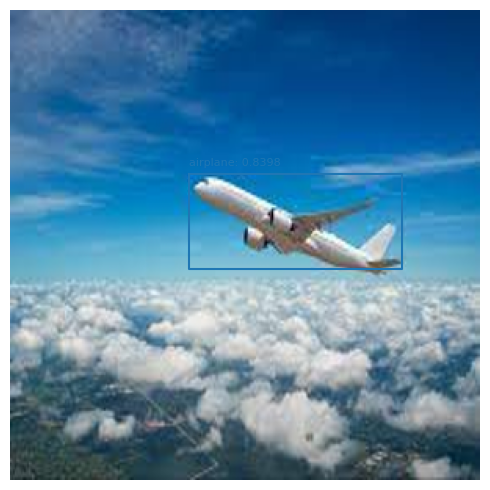

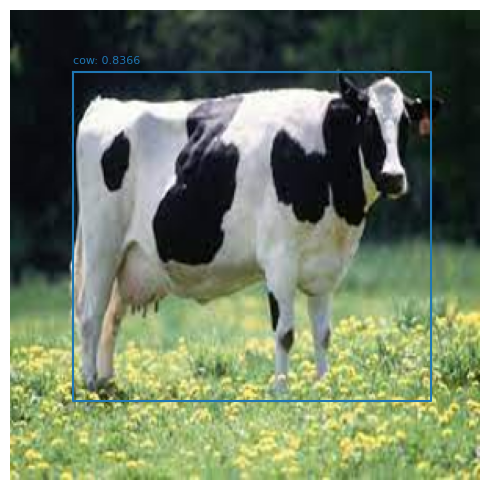

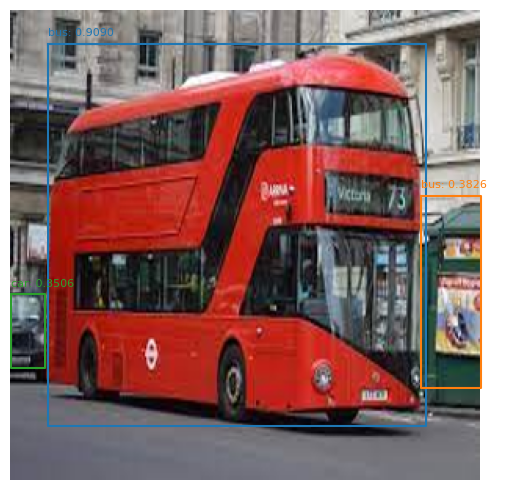

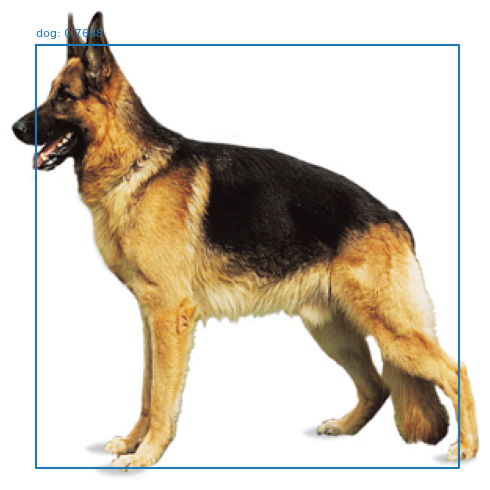

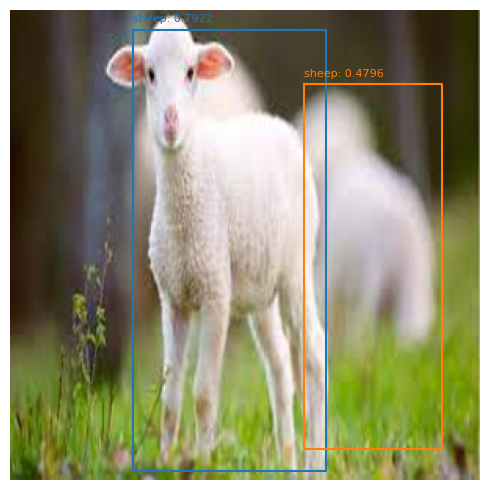

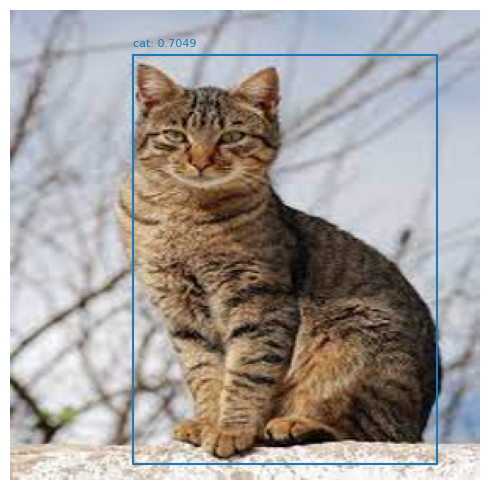

In [9]:
bb = SwinTransformerV2Small_window16(input_shape=(256, 256, 3), pretrained=None, num_classes=0)
model = yolor.YOLOR(backbone=bb, input_shape=(256, 256, 3), rescale_mode='torch')  # Default rescale_mode from coco_train_script.py is "torch"
model.load_weights(model_path+'/swinCoco.h5')  # Load the trained weights

dir=os.listdir(sample_images)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(18,18))

i=1

for i in dir:
  imm=np.array(Image.open(sample_images+'/'+i).resize((300,300)))

# Detect

  preds = model(model.preprocess_input(imm))
  bboxs, lables, confidences = model.decode_predictions(preds)[0]

# Show

  data.show_image_with_bboxes(imm, bboxs, lables, confidences)
